In [2]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

In [5]:
img_shape = (28, 28, 1)
btach_size = 16

# 2D plane for latent space
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                 padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu',
                 strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### Decoder Implementation

In [9]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                          padding='same',
                          activation='relu',
                          strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                 padding='same',
                 activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

### Custom Loss Layer

In [10]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 

/home/dhodun/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


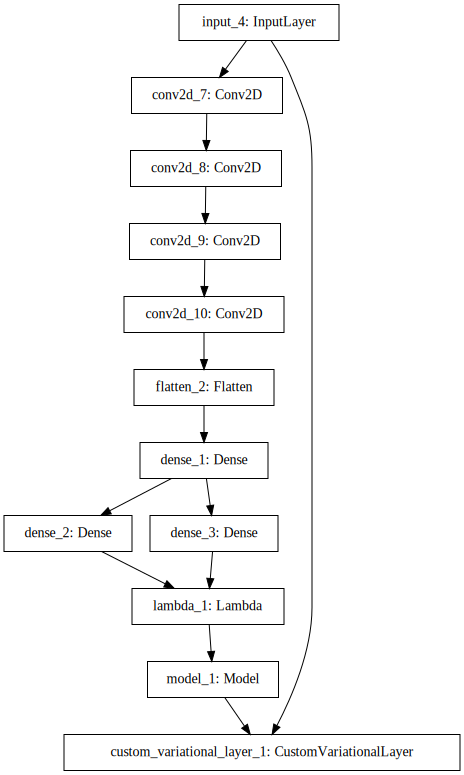

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))